In [3]:
import json 
import matplotlib.pyplot as plt
import urllib
from datetime import datetime
from math import exp,floor
import numpy as np
from scipy.integrate import odeint #Va nous permettre de résoudre des équations différentielles
from scipy.optimize import leastsq,least_squares,curve_fit #Importation de la méthode des moindres carrés
import scipy.stats as stats
plt.rcParams['figure.figsize'] = [12, 9]

url="https://www.data.gouv.fr/fr/datasets/r/a7596877-d7c3-4da6-99c1-2f52d418e881"
response = urllib.request.urlopen(url)

covid_dict= json.loads(response.read())

#champs de 'PaysData' : ["Date","Pays","Infection","Deces","Guerisons","TauxDeces","TauxGuerison","TauxInfection"]
#champs de 'GlobalData' : ["Date","Infection","Deces","Guerisons","TauxDeces","TauxGuerison","TauxInfection"]

In [4]:
#####################   FONCTIONS   #####################

############  Recuperation de données  ############
def renvoyer_datetime(chaine_temps):#permet de transformer une chaine de caractère format ISO en datetime
    return datetime.fromisoformat(chaine_temps)

def temps_lisible(chaine_temps): #on veut renvoyer une chaine de caractères au format JJ/MM
    format='%d/%m' #format reconnu par strftime %d pour jour format JJ et %m pour mois format MM
    format_datetime = renvoyer_datetime(chaine_temps) #chainetemps est une chaine de caractères 
    return format_datetime.strftime(format) #convertit un format datetime en chaine de caractère

def recup_pays(pays):
    sortie=[]
    if pays=="Monde": #Possibilité de considérer le "monde" comme un pays
        sortie=[donnee for donnee in covid_dict['GlobalData']]
    else :
        sortie= [donnee for donnee in covid_dict['PaysData'] if donnee['Pays']==pays]
    sortie.reverse()
    return sortie

def recup_champ(table,champ):
    sortie= [donnee[champ] for donnee in table] #Fonction servant à simplifier les écritures
    #sortie.reverse()
    return sortie

def recup_graphiq(table,champ): #probablement pas obligatoire, associer chaque donnée à une date
    sortie= [[donnee[champ],donnee['Date']] for donnee in table] 
    return np.transpose(sortie)
############  Réglages de graphique  ############

def reglage_axe_x(x_entree,nbvaleurs):
    position_xticks=[floor(k*len(x_entree)/nbvaleurs) for k in range(nbvaleurs)] #subdivisions égales de l'axe
    position_xticks.append(len(x_entree)-1) #on n'oublie pas la dernière valeur
    x_partiel=[temps_lisible(x_entree[pos]) for pos in position_xticks ]
    plt.xticks(position_xticks,x_partiel)

############  Fonctions mathématiques  ############

def derivee(tableau,dx):
    return np.diff(tableau)/dx

def normale(alpha,mu,sigma,t):
    return alpha*stats.norm.pdf(t, mu, sigma)

def indicatrice_sup(x,a): #indicatrice mathématique renvoie 1 si x>=a 0 sinon
    return int(x>=a)

def SIRD(beta0,k,gamma,delta,lamda,t,h=[],beta1=0,initial=[1,1,0,0]):
    #Ic : nombre de personnes contagieuses
    #Wc : nombre de personnes infectées
    #L : nombre de personnes infectées isolées qui mourront sans infecter d'autres personnes
    #D : nombre de personnes mortes
    #Ic0,Wc0,L0,D0=1,1,0,0 #peut être à donner en paramètre à optimiser?
    conditions_initiales=np.array(initial,dtype='float64')
    
    beta_old= lambda x : beta0*exp(-k*x)+beta1 #la forme exponentielle ne nous avance pas plus
    
    def beta_inflexion(x):
        tab_pts_inflexion = np.array([t[floor(k*len(t)/len(h))] for k in range(len(h))],dtype='float64')
        tab_indicatrices= np.array([indicatrice_sup(x,tau) for tau in tab_pts_inflexion],dtype='float64')
        return beta0 + x*(k+np.dot(h,tab_indicatrices)) #produit scalaire donc comprend somme et produit terme à terme

    if(len(h)==0): #doit détecter automatiquement si on utilise le modèle à inflexion
        beta= beta_old
    else: 
        beta= beta_inflexion
    
    def modele(y,t1):
        Ic=y[0]
        Wc=y[1]
        L=y[2]
        D=y[3]
        
        d_Ic= (beta(t1)-gamma-delta)*Ic
        d_Wc = beta(t1)*Ic
        d_L = delta*Ic - lamda*L
        d_D = lamda*L
        
        return np.array([d_Ic,d_Wc,d_L,d_D],dtype='float64')
    
    resultat= odeint(modele,conditions_initiales,t)
    
    return np.transpose(resultat) #on renvoie la transposée sinon Ic,Wc,L,D seront sur les colonnes, peu pratique
    
def cout(theta): #fonction de cout pour le modele SIRD
    nb_jours=len(Table_infection)
    
    #theta contient tous nos arguments pour la fonction SIRD
    #[beta0,k,gamma,delta,lamda] = theta 
    estime=SIRD(theta[0],theta[1],theta[2],theta[3],theta[4],np.arange(nb_jours))
    
    infectes,deces = estime[1],estime[3]
    
    residus_infectes=np.array(Table_infection-infectes,dtype='float64')
    residus_deces= np.array(Table_deces-deces,dtype='float64')
    
    #print(residus_infectes**2+residus_deces**2)
    return np.sum(residus_infectes**2+residus_deces**2)

def cout_exp_double(theta): #fonction de cout pour le modele SIRD
    nb_jours=len(Table_infection)
    
    #theta contient tous nos arguments pour la fonction SIRD
    #[beta0,k,gamma,delta,lamda] = theta 
    estime=SIRD(theta[0],theta[1],theta[2],theta[3],theta[4],np.arange(nb_jours),[],theta[5])
    
    infectes,deces = estime[1],estime[3]
    
    residus_infectes=np.array(Table_infection-infectes,dtype='float64')
    residus_deces= np.array(Table_deces-deces,dtype='float64')
    
    #print(residus_infectes**2+residus_deces**2)
    return np.sum(residus_infectes**2+residus_deces**2)

def cout_exp_2(theta): #fonction de cout pour le modele SIRD
    nb_jours=len(Table_infection)
    
    #theta contient tous nos arguments pour la fonction SIRD
    #[beta0,k,gamma,delta,lamda] = theta 
    estime=SIRD(theta[0],theta[1],theta[2],theta[3],theta[4],np.arange(nb_jours),[],theta[5],[theta[6],theta[7],theta[8],theta[9]])
    
    infectes,deces = estime[1],estime[3]
    
    residus_infectes=np.array(Table_infection-infectes,dtype='float64')
    residus_deces= np.array(Table_deces-deces,dtype='float64')
    
    #print(residus_infectes**2+residus_deces**2)
    #return np.sum(residus_infectes**2+residus_deces**2)
    return np.sum(residus_infectes**2)


def cout2(theta): #fonction de cout pour le modèle normal
    nb_jours=len(Table_infection)
    
    #theta contient tous nos arguments pour la fonction SIRD
    #[alpha,sigma,mu] = theta 
    estime=normale(theta[0],theta[1],theta[2],np.arange(nb_jours))

    residus_infectes=np.array(Table_infection-estime,dtype='float64')

    #print(residus_infectes**2)
    return np.sum(abs(residus_infectes))

def cout_inflexion(theta): #fonction de cout pour le modele SIRD
    nb_jours=len(Table_infection)
    
    #theta contient tous nos arguments pour la fonction SIRD
    #[beta0,k,gamma,delta,lamda,h] = theta 
    
    h=theta[5:] #h se situe après les 5 variables 
    print('h=',h)
    estime=SIRD(theta[0],theta[1],theta[2],theta[3],theta[4],np.arange(nb_jours),h)
    
    infectes,deces = estime[1],estime[3]
    
    residus_infectes=np.array(Table_infection-infectes,dtype='float64')
    residus_deces= np.array(Table_deces-deces,dtype='float64')
    
    #print(residus_infectes**2+residus_deces**2)
    return np.sum(np.sqrt(residus_infectes**2+residus_deces**2))

In [24]:
for elem in covid_dict['PaysData'][0]:
    print (elem)

Date
Pays
Infection
Deces
Guerisons
TauxDeces
TauxGuerison
TauxInfection


In [12]:
table_France=recup_pays("France")
global Table_infection 
Table_infection = recup_champ(table_France,'Infection')
global Table_deces
Table_deces= recup_champ(table_France,'Deces')


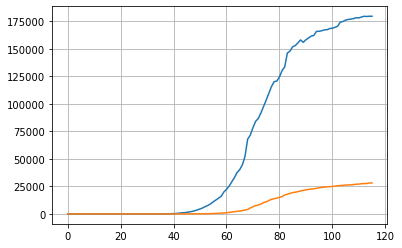

In [104]:
y=recup_champ(table_France,'Infection')
x=range(len(y))
y2=recup_champ(table_France,'Deces')
plt.plot(x,y,y2)
plt.grid()
# affichage de données basiques OK !

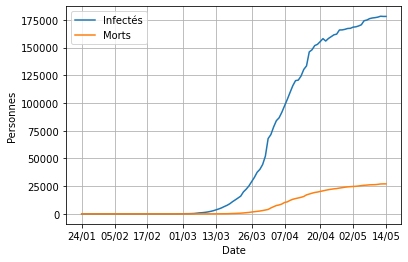

In [161]:
y=recup_champ(table_France,'Infection')
x=recup_champ(table_France,'Date')
y2=recup_champ(table_France,'Guerisons')
y3=recup_champ(table_France,'Deces')
graph=recup_graphiq(table_France,'Infection')
reglage_axe_x(graph[1],9)
plt.plot(graph[1],graph[0].astype(int),label='Infectés')
plt.plot(graph[1],y3, label='Morts')
plt.legend()

plt.xlabel('Date')
plt.ylabel('Personnes')
plt.grid()

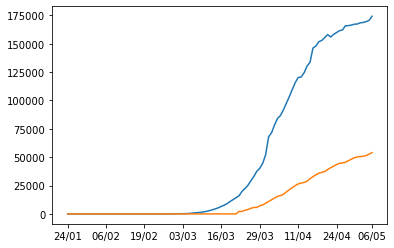

In [8]:
reglage_axe_x(x,8)
plt.plot(x,y,y2)
#affichage lisible de l'axe des temps OK!

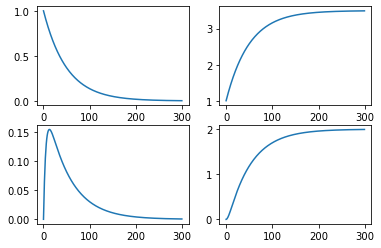

In [33]:
x=np.array(range(300))
y=SIRD(0.05,0,0.03,0.04,0.2,x)
plt.subplot(221)
plt.plot(x,y[0])
plt.subplot(222)
plt.plot(x,y[1])
plt.subplot(223)
plt.plot(x,y[2])
plt.subplot(224)
plt.plot(x,y[3])
#le modèle SIRD est opérationnel !

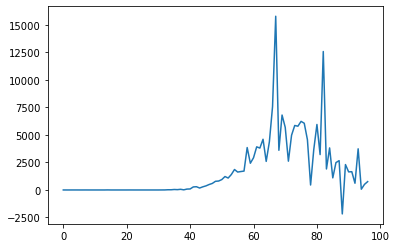

In [46]:
y=recup_champ(table_France,'Infection')
y.reverse()
derivee_infection=derivee(y,1)

plt.plot(range(len(derivee_infection)),derivee_infection)

#fonction dérivée OK ! 

In [205]:
theta0=[0.05, 0, 0.03, 0.04, 0.2]
cout(theta0)
#Fonction de cout OK!

769268929443.2625

In [204]:
leastsq(cout,theta0) #on préfèrera utiliser least_square plutot que leastsq

TypeError: Improper input: N=5 must not exceed M=1

In [167]:
theta2=np.array([ 0.256, 1.0/14.39, 0.017, 0.024 , 0.03549158,0.21335057])
least_squares(cout_exp_double,theta2)

<ipython-input-149-e47c9ebdf3d7>:74: RuntimeWarning: overflow encountered in double_scalars
  d_Ic= (beta(t1)-gamma-delta)*Ic
<ipython-input-149-e47c9ebdf3d7>:75: RuntimeWarning: overflow encountered in double_scalars
  d_Wc = beta(t1)*Ic
<ipython-input-149-e47c9ebdf3d7>:76: RuntimeWarning: invalid value encountered in double_scalars
  d_L = delta*Ic- lamda*L
c:\users\azobinou\appdata\local\programs\python\python38-32\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-149-e47c9ebdf3d7>:113: RuntimeWarning: overflow encountered in square
  return np.sum(residus_infectes**2+residus_deces**2)


 active_mask: array([0., 0., 0., 0., 0., 0.])
        cost: 1.2214876292324563e+21
         fun: array([4.94264631e+10])
        grad: array([-4.78802978e+21, -5.18313535e+22, -6.57473705e+22, -4.97141661e+22,
        2.70517716e+22,  5.80546265e+22])
         jac: array([[-9.68717865e+10, -1.04865593e+12, -1.33020585e+12,
        -1.00582083e+12,  5.47313522e+11,  1.17456566e+12]])
     message: 'The maximum number of function evaluations is exceeded.'
        nfev: 600
        njev: 586
  optimality: 6.5747370544832014e+22
      status: 0
     success: False
           x: array([0.3613177 , 0.03617872, 0.10451954, 0.12053631, 0.03834543,
       0.22673815])

In [ ]:
# On constate que la solution ne converge pas vers un optimum , mais cela nous renvoie quand meme des 
# Paramètres utilisables (x:...) que l'on va reporter dans la suite

Text(0, 0.5, 'décès')

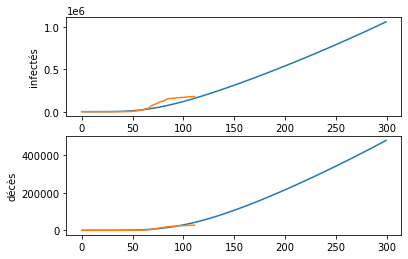

In [219]:
#x=np.array(range(len(Table_infection)))
x=np.arange(1,300)
y=SIRD(  0.3613177 , 0.03617872, 0.10451954, 0.12053631, 0.03834543,x,[],0.22673) #valeurs précédentes
plt.subplot(211)
plt.plot(x,y[1],Table_infection)
plt.ylabel('infectés')

plt.subplot(212)
plt.plot(x,y[3],Table_deces)
plt.ylabel('décès')

In [209]:
# Vérifions que ce n'est pas least_square le problème : modèle normal
theta_norm=[5.44190999e+06, 30 , 10] #valeurs au jugé, point de départ
valeurs_opti= least_squares(cout2,theta_norm).x

Text(0, 0.5, 'Infectés')

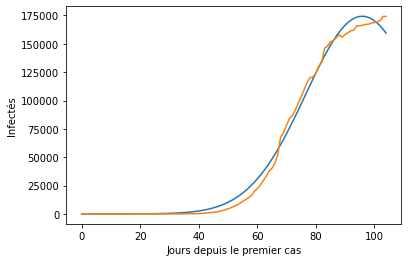

In [211]:
x=np.array(range(len(Table_infection)))
plt.plot(x,normale(valeurs_opti[0],valeurs_opti[1],valeurs_opti[2],x),Table_infection)
plt.xlabel('Jours depuis le premier cas')
plt.ylabel('Infectés')

In [149]:
cout2([1.74190999e+06, 5.14545124e+01, 7.35542739e+00])

347103621412.0231

<ipython-input-121-0008ffaf3c04>:8: RuntimeWarning: invalid value encountered in double_scalars
  tab_indicatrices= np.array([(1+tau/x)*indicatrice_sup(x,tau) for tau in tab_pts_inflexion])
<ipython-input-121-0008ffaf3c04>:8: RuntimeWarning: divide by zero encountered in double_scalars
  tab_indicatrices= np.array([(1+tau/x)*indicatrice_sup(x,tau) for tau in tab_pts_inflexion])


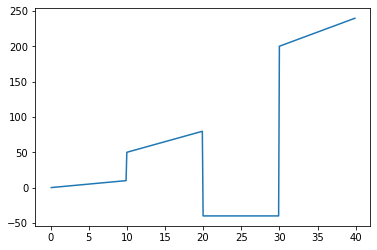

In [121]:
#test de notre fonction beta à inflexions:
t=np.arange(0,40,0.1)
h=np.array([1,2,-3,4],dtype='float64')
a=0
beta0=0
def beta_inflexion(x):
    tab_pts_inflexion = np.array([t[floor(k*len(t)/len(h))] for k in range(len(h))])
    tab_indicatrices= np.array([(1+tau/x)*indicatrice_sup(x,tau) for tau in tab_pts_inflexion])
    return beta0 + x*(a+np.dot(h,tab_indicatrices)) #produit scalaire donc comprend somme et produit terme à terme

#print(np.vectorize(beta_inflexion)(t))
#plt.plot(t[:-1],derivee(np.vectorize(beta_inflexion)(t),0.1))
plt.plot(t,np.vectorize(beta_inflexion)(t),0.1)
#plt.axis([0,40,0,10])

#on a bien les pentes attendues, c'est OK ! 

In [30]:
#test de la nouvelle fonction de cout à inflexion :
htest=[0.05,-0.06,-0.03]
thetatest=[0.0012199117,0,-0.001517427,0.001601763,0.002002899]+htest
cout_inflexion(thetatest)

2516367385633121.0

### La fonction est OK !

In [22]:
#Peut on optimiser ces valeurs cette fois?
least_squares(cout_inflexion,thetatest)

KeyboardInterrupt: 

### Après 25 min de calculs, apparemment non.

h= [0.05, -0.06, 0.01]


Text(0, 0.5, 'décès')

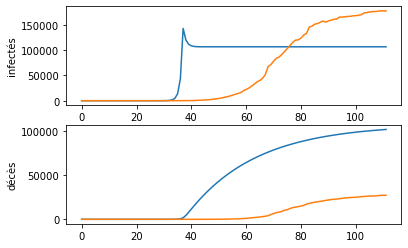

In [182]:
x=np.array(range(len(Table_infection)))
htest=[0.05,-0.06,0.01]
theta_trace= [0.005,  -0.0003, -0.00015,  0.615,  0.04002899]+htest
y=SIRD(theta_trace[0],theta_trace[1],theta_trace[2],theta_trace[3],theta_trace[4],x,htest) #valeurs précédentes
cout_inflexion(theta_trace)
plt.subplot(211)
plt.plot(x,y[1],Table_infection)
plt.ylabel('infectés')
#plt.legend("reel","simulé")

plt.subplot(212)
plt.plot(x,y[3],Table_deces)
plt.ylabel('décès')
#SIRD(beta0,k,gamma,delta,lamda,t,h=[])

In [51]:
theta_pif=[0.01,  0., -0.00015,  0.61763,  0.005002899]+htest
least_squares(cout_inflexion,thetatest)


<ipython-input-14-1373eeb23122>:127: RuntimeWarning: overflow encountered in square
  return np.sum(np.sqrt(residus_infectes**2+residus_deces**2))


KeyboardInterrupt: 

49417275888.62107


Text(0, 0.5, 'décès')

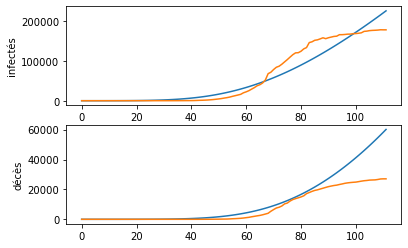

In [207]:
x=np.array(range(len(Table_infection)))
CI_test=[1,1,0,0]
beta1=[0.22673]
theta_trace= [0.3613177 , 0.03617872, 0.10451954, 0.12053631, 0.03834543]+beta1+CI_test
y=SIRD(theta_trace[0],theta_trace[1],theta_trace[2],theta_trace[3],theta_trace[4],x,[],theta_trace[5],CI_test) #valeurs précédentes
print(cout_exp_2(theta_trace))
plt.subplot(211)
plt.plot(x,y[1],Table_infection)
plt.ylabel('infectés')
#plt.legend("reel","simulé")

plt.subplot(212)
plt.plot(x,y[3],Table_deces)
plt.ylabel('décès')
#SIRD(beta0,k,gamma,delta,lamda,t,h=[])

In [208]:
#Peut on optimiser ces valeurs cette fois?
least_squares(cout_exp_2,theta_trace)

 active_mask: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
        cost: 5.689514847722478e+20
         fun: array([3.37328174e+10])
        grad: array([-4.24016243e+21, -1.89908895e+22, -2.20104432e+22, -1.44867737e+22,
        1.83050713e+22,  1.82112482e+22, -2.30809005e+20, -4.89638591e+15,
        2.44560228e+16,  2.62435922e+16])
         jac: array([[-1.25698437e+11, -5.62979644e+11, -6.52493475e+11,
        -4.29456382e+11,  5.42648753e+11,  5.39867395e+11,
        -6.84226884e+09, -1.45152000e+05,  7.24992000e+05,
         7.77984000e+05]])
     message: 'The maximum number of function evaluations is exceeded.'
        nfev: 1000
        njev: 965
  optimality: 2.2010443247387555e+22
      status: 0
     success: False
           x: array([ 3.64931980e-01,  3.07366013e-02,  1.12578226e-01,  1.24578202e-01,
        3.02934350e-02,  2.20924095e-01,  1.00017485e+00,  1.00000001e+00,
       -1.26004063e-08, -1.32609962e-08])

274476556834.40442


Text(0, 0.5, 'décès')

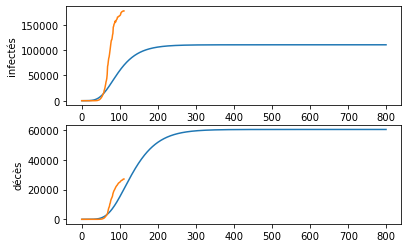

In [256]:
t_opt=[3.64931980e-01,  3.07366013e-02,  1.12578226e-01,  1.34578202e-01,
        3.02934350e-02,  2.20924095e-01,  1.00017485e+00,  1.00000001e+00,
       -1.26004063e-08, -1.32609962e-08]
#x=np.array(range(len(Table_infection)))
x=np.arange(1,800)
theta_trace= t_opt
y=SIRD(theta_trace[0],theta_trace[1],theta_trace[2],theta_trace[3],theta_trace[4],x,[],theta_trace[5],theta_trace[6:]) #valeurs précédentes
print(cout_exp_2(theta_trace))
plt.subplot(211)
plt.plot(x,y[1],Table_infection)
plt.ylabel('infectés')
#plt.legend("reel","simulé")

plt.subplot(212)
plt.plot(x,y[3],Table_deces)
plt.ylabel('décès')
#SIRD(beta0,k,gamma,delta,lamda,t,h=[])

In [239]:
least_squares(cout_exp_2,t_opt)

c:\users\azobinou\appdata\local\programs\python\python38-32\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-238-513236364f34>:129: RuntimeWarning: overflow encountered in square
  return np.sum(residus_infectes**2)


 active_mask: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
        cost: 4.244044092833288e+22
         fun: array([2.91343237e+11])
        grad: array([-2.31143257e+23, -3.03574446e+23, -1.12931800e+23, -1.12931810e+23,
        2.38668380e+15,  8.49761594e+22, -1.68296514e+22, -1.65874462e+18,
       -4.77336760e+15, -7.16005140e+15])
         jac: array([[-7.93370935e+11, -1.04198213e+12, -3.87624579e+11,
        -3.87624616e+11,  8.19200000e+03,  2.91670266e+11,
        -5.77657183e+10, -5.69343788e+06, -1.63840000e+04,
        -2.45760000e+04]])
     message: 'The maximum number of function evaluations is exceeded.'
        nfev: 1000
        njev: 990
  optimality: 3.03574446303504e+23
      status: 0
     success: False
           x: array([4.23942396e-01, 3.47933727e-02, 1.10435047e-01, 1.23537072e-01,
       3.36321907e-02, 2.30000972e-01, 1.00403684e+00, 1.00000038e+00,
       1.02322508e-08, 1.66340024e-08])

### Virage à 180° complet : on refait une fonction SIRD correcte

In [148]:
def SIRD_new(beta0,k,gamma,mu,t,beta1=0,initial=[1,1,0,1]):

    
    beta= lambda x : beta0+beta1*exp(-k*x) #la forme exponentielle ne nous avance pas plus
    
    def modele(y,t1):
        S,I,R,D=y
        
        dS= - beta(t1) * S * I
        dI= (beta(t1) * S - gamma - mu)*I
        dR= gamma*I
        dD= mu*I
        
        return dS,dI,dR,dD
    
    resultat= odeint(modele,np.array(initial,dtype='float64' ),t).T
    
    return resultat #on renvoie la transposée sinon Ic,Wc,L,D seront sur les colonnes, peu pratique

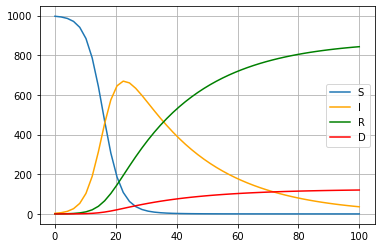

In [548]:
#x=np.array(range(len(Table_infection)))
x=np.linspace(0,100)
res=SIRD_new(0.0004,0,0.035,0.005,x,0,[997,3,0,0]) #valeurs précédentes
#print(res)
S,I,R,D=res
fig = plt.figure()
ax = fig.add_subplot(111, facecolor='#ffffff', axisbelow=True)
ax.plot(x,S,label='S')
ax.plot(x,I,'orange',label='I')
ax.plot(x,R,'g',label='R')
ax.plot(x,D,'r',label='D')
ax.grid()
ax.legend()

### En comparaison , ce qu'on doit avoir d'après une simulation disponible sur wikipédia:

![title](SIRD.png)

### Résultat identique , fonction SIRD pure semble OK ! , passons à la fonction de coût :

In [57]:
def cout_exp_simple(theta): #fonction de cout pour le modele SIRD
    nb_jours=len(Table_deces)
    
    #theta contient tous nos arguments pour la fonction SIRD
    #[beta0,k,gamma,delta,lamda] = theta 
    estime=SIRD_new(theta[0],theta[1],theta[2],theta[3],np.arange(nb_jours),theta[4])
    
    infectes,deces = estime[1],estime[3]
    
    #residus_infectes=np.array(Table_infection-infectes,dtype='float64')
    residus_deces= np.array(Table_deces-deces,dtype='float64')

    return np.abs(residus_deces) #On ne va fit que sur les décès

In [420]:
theta_essai=[0.5,0.02,0.035,0.005,0.5]
cout_exp_simple(theta_essai)

array([1.00000000e+00, 1.05012380e+00, 1.10697406e+00, 1.16159538e+00,
       1.21407498e+00, 1.26449682e+00, 1.31294158e+00, 1.35948680e+00,
       1.40420696e+00, 1.44717361e+00, 1.48845553e+00, 1.52811875e+00,
       1.56622676e+00, 1.60284053e+00, 1.63801867e+00, 1.67181742e+00,
       1.70429093e+00, 1.73549114e+00, 1.76546794e+00, 1.79426936e+00,
       1.82194145e+00, 1.84852851e+00, 8.74073064e-01, 8.98616006e-01,
       9.22196613e-01, 9.44852612e-01, 9.66620253e-01, 9.87534372e-01,
       1.00762843e+00, 1.02693459e+00, 1.04548375e+00, 1.06330559e+00,
       1.08042862e+00, 9.68802711e-02, 1.12686804e-01, 1.27873572e-01,
       1.42464856e-01, 1.56484006e-01, 8.30046539e-01, 1.81710523e+00,
       1.80467135e+00, 3.79272502e+00, 6.78124710e+00, 8.77021925e+00,
       1.67596238e+01, 2.27494438e+01, 3.07396630e+01, 4.57302657e+01,
       5.87212368e+01, 7.67125620e+01, 8.87042273e+01, 1.24696219e+02,
       1.45688526e+02, 1.72681133e+02, 2.61674031e+02, 3.69667207e+02,
      

### La fonction de cout semble OK aussi, passons au fitting !

In [93]:
def afficheur(theta,longueur):
    x=np.arange(1,longueur)
    initiaux= theta[5:]
    
    #theta contient tous nos arguments pour la fonction SIRD
    #[beta0,k,gamma,mu,beta1] = theta 
    if(len(initiaux)==0):
        y=SIRD_new(theta[0],theta[1],theta[2],theta[3],x,theta[4])
    else:
        y=SIRD_new(theta[0],theta[1],theta[2],theta[3],x,theta[4],initiaux)
        
    plt.plot(x,y[3],label='Simulation')
    plt.plot(x[:min(len(Table_deces),longueur)],Table_deces,label='Réel')
    plt.xlabel('Jours')
    plt.ylabel('D')
    plt.legend()
    plt.grid()


In [9]:
theta_essai=[0.4,1./14,0.035,0.005,0.4]
solution_opti= least_squares(cout_exp_simple,theta_essai)
print(solution_opti)

 active_mask: array([0., 0., 0., 0., 0.])
        cost: 2673487431.6927214
         fun: array([1.00000000e+00, 1.59961421e+00, 2.44681742e+00, 3.41178282e+00,
       4.45878114e+00, 5.58557256e+00, 6.79679785e+00, 8.09858057e+00,
       9.49766539e+00, 1.10013224e+01, 1.26173669e+01, 1.43541995e+01,
       1.62208480e+01, 1.82270153e+01, 2.03831297e+01, 2.27003985e+01,
       2.51908663e+01, 2.78674793e+01, 3.07441506e+01, 3.38358323e+01,
       3.71585952e+01, 4.07297113e+01, 4.35677435e+01, 4.76926406e+01,
       5.21258451e+01, 5.68904003e+01, 6.20110728e+01, 6.75144799e+01,
       7.34292279e+01, 7.97860600e+01, 8.66180206e+01, 9.39606224e+01,
       1.01852032e+02, 1.09333269e+02, 1.18448420e+02, 1.28244863e+02,
       1.38773519e+02, 1.50089119e+02, 1.61250480e+02, 1.73320817e+02,
       1.87368070e+02, 2.00465256e+02, 2.13690850e+02, 2.29129194e+02,
       2.39870930e+02, 2.54013478e+02, 2.67661539e+02, 2.75927649e+02,
       2.87932725e+02, 2.96806761e+02, 3.13689442e+02, 3.08

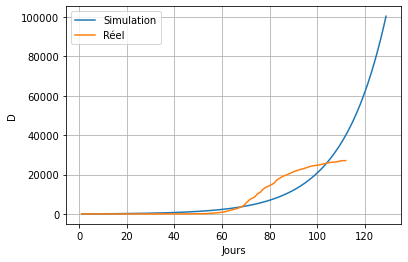

In [423]:
afficheur(solution_opti.x,130)

### Cela n'a pas l'air de fonctionner, essayons de mettre les conditions initiales à optimiser aussi:

In [214]:
def cout_exp_simple(theta): #fonction de cout pour le modele SIRD
    nb_jours=len(Table_deces)
    initiaux= theta[5:]
    print(initiaux)
    
    #theta contient tous nos arguments pour la fonction SIRD
    #[beta0,k,gamma,mu,beta1] = theta 
    if(len(initiaux)==0):
        estime=SIRD_new(theta[0],theta[1],theta[2],theta[3],np.arange(nb_jours),theta[4])
    else:
        estime=SIRD_new(theta[0],theta[1],theta[2],theta[3],np.arange(nb_jours),theta[4],initiaux)

    
    infectes,deces = estime[1],estime[3]
    
    #residus_infectes=np.array(Table_infection-infectes,dtype='float64')
    residus_deces= np.array(Table_deces-deces,dtype='float64')
    
    #print(residus_infectes**2+residus_deces**2)
    return np.log10(np.sum(residus_deces**2)/len(residus_deces)) #On ne va fit que sur les décès

In [215]:
cout_exp_simple([0.05,0.0,0.04,0.012,0])

[]


8.502459921440586

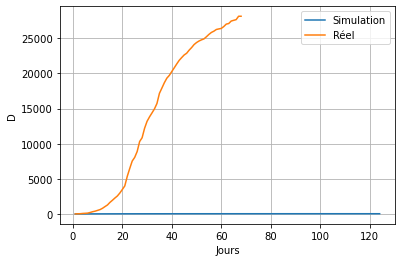

In [207]:
population=6e3
infectes=10
cond_init=[Table_infection[0]*60,Table_infection[0],0,Table_deces[0]]
theta_essai2=[0.05,0.0,0.04,0.012,0]+cond_init
afficheur(theta_essai2,125)
#plt.axis([0,125,0,10])

In [208]:
solution_opti2= least_squares(cout_exp_simple,theta_essai2)
print(solution_opti2)
afficheur(solution_opti2.x,200)

[  0. 120.   2.   0.  61.]


ValueError: too many values to unpack (expected 4)

In [131]:
print(Table_deces[0])

1100


### Essayons le modèle du papier scientifique
https://www.medrxiv.org/content/10.1101/2020.03.19.20039388v3.full.pdf

In [546]:
def SIRD_tout_variable(beta0,k,gamma0,mu,t,beta1=0,gamma1=0,initial=[1,1,0,1]):

    # cette fois ci, tous les coeff sont des constantes
    beta= lambda x : beta0#+beta1*np.exp(-k*x) #la forme exponentielle ne nous avance pas plus
    gamma = lambda x : gamma0 #+ gamma1/(1+np.exp(-x+1/30) )
    
    def modele(y,t1):
        S,I,R,D=y
        
        dS= - beta(t1) * S * I
        dI= (beta(t1) * S - gamma(t1) - mu)*I
        dR= gamma(t1)*I
        dD= mu*I
        
        return dS,dI,dR,dD
    
    resultat= odeint(modele,np.array(initial,dtype='float64' ),t).T
    
    return resultat #on renvoie la transposée sinon Ic,Wc,L,D seront sur les colonnes, peu pratique

In [547]:
def cout_exp_scientifique(theta): #fonction de cout pour le modele SIRD
    nb_jours=len(Table_deces)
    initiaux= theta[6:]
    
    #theta contient tous nos arguments pour la fonction SIRD
    #[beta0,k,gamma,mu,beta1] = theta 
    if(len(initiaux)==0):
        estime=SIRD_tout_variable(theta[0],theta[1],theta[2],theta[3],np.arange(nb_jours),theta[4],theta[5])
    else:
        estime=SIRD_tout_variable(theta[0],theta[1],theta[2],theta[3],np.arange(nb_jours),theta[4],theta[5],initiaux)

    
    infectes,deces = estime[1],estime[3]
    
    residus_infectes=np.array(Table_infection-infectes,dtype='float64')
    residus_infectes_variation=np.array(derivee(Table_infection,1)-derivee(infectes,1),dtype='float64')
    # On prend cette fois en compte le résidu des dérivées pour fit aussi sur le nombre de nouveaux cas!
    residus_deces= np.array(Table_deces-deces,dtype='float64')
    residus_deces_variation=np.array(derivee(Table_deces,1)-derivee(deces,1),dtype='float64')
    return 1/(len(residus_deces)-1)*(residus_deces[:-1]**2+residus_infectes[:-1]**2+residus_infectes_variation**2+residus_deces_variation**2) #On ne va fit que sur les décès

In [548]:
def afficheur2(theta,longueur):
    x=np.arange(1,longueur)
    initiaux= theta[6:]
    print(theta)
    
    #theta contient tous nos arguments pour la fonction SIRD
    #[beta0,k,gamma0,mu,beta1,gamma1] = theta 
    if(len(initiaux)==0):
        y=SIRD_tout_variable(theta[0],theta[1],theta[2],theta[3],x,theta[4],theta[5])
    else:
        y=SIRD_tout_variable(theta[0],theta[1],theta[2],theta[3],x,theta[4],theta[5],initiaux)
    
    plt.subplot(221)
    plt.plot(x,y[3],label='Simulation')
    plt.plot(x[:min(len(Table_deces),longueur)],Table_deces[:min(len(Table_deces),longueur)],label='Réel')
    plt.xlabel('Jours')
    plt.ylabel('D')
    plt.legend()
    plt.grid()
    
    plt.subplot(222)
    plt.plot(x,y[1],label='Simulation')
    plt.plot(x[:min(len(Table_infection),longueur)],Table_infection[:min(len(Table_infection),longueur)],label='Réel')
    plt.xlabel('Jours')
    plt.ylabel('I')
    plt.legend()
    plt.grid()
    
    plt.subplot(223)
    plt.plot(x[:-1],derivee(y[1],1),label='Simulation')
    plt.plot(x[:min(len(Table_infection),longueur)-1],derivee(Table_infection[:min(len(Table_infection),longueur)],1),label='Réel')
    plt.xlabel('Jours')
    plt.ylabel('I (nouveaux cas)')
    plt.legend()
    plt.grid()
    
    plt.subplot(224)
    plt.plot(x[:-1],derivee(y[1],1),label='Simulation')
    plt.plot(x[:min(len(Table_infection),longueur)-1],derivee(Table_infection[:min(len(Table_infection),longueur)],1),label='Réel')
    plt.xlabel('Jours')
    plt.ylabel('D (nouveaux cas)')
    plt.legend()
    plt.grid()

[0.05, 0.07142857142857142, 0.015, 0.009, 0.05, 0.061]


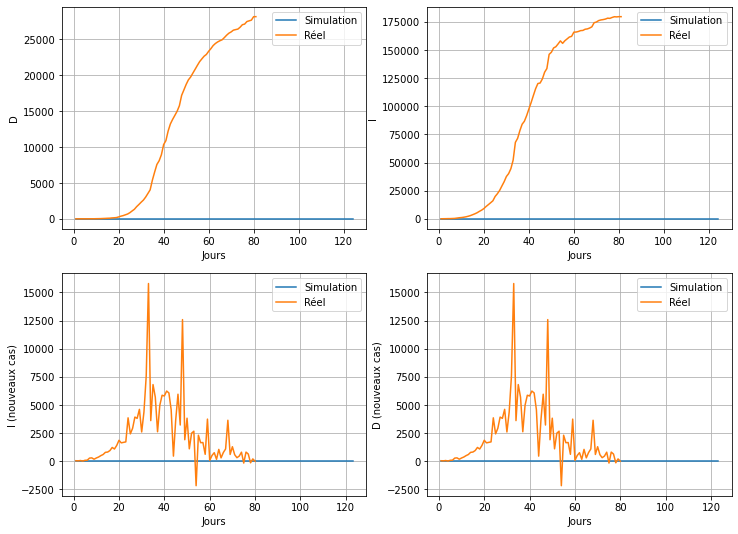

In [549]:
cond_init=[Table_infection[0]*70,Table_infection[0],0,Table_deces[0]]
theta_essai3=[0.05,1/14,0.015,0.009,0.05,0.061]#+cond_init
afficheur2(theta_essai3,125)
#plt.axis([0,125,0,10])

### Et si on essayait de maintenant fit sur le nombre de nouveaux cas plutôt?

c:\users\azobinou\appdata\local\programs\python\python38-32\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\users\azobinou\appdata\local\programs\python\python38-32\lib\site-packages\scipy\optimize\minpack.py:454: RuntimeWarning: Number of calls to function has reached maxfev = 2200.
  warnings.warn(errors[info][0], RuntimeWarning)


2876 61
[ 1.10184147e-06  7.14285714e-02 -1.02745793e-02  5.13491010e-03
  5.00000000e-02  6.10000000e-02  1.41877145e+05  3.61790935e+03
 -4.95088744e+06  8.12755325e+01]


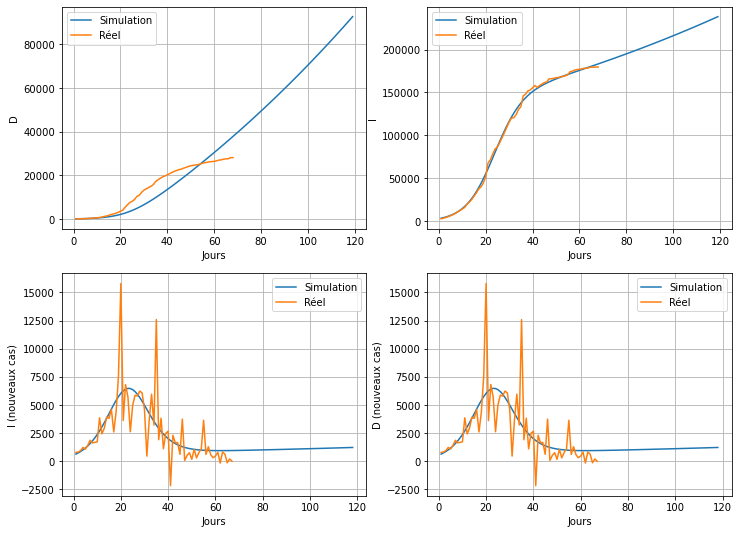

In [564]:
cond_init=[Table_infection[0]*32,Table_infection[0],20,Table_deces[0]/2]
# le facteur multiplicatif de 32 est arbitraire, nous partons du principe que le nombre d'infectés recensé n'est qu'une 
# petite partie de la population susceptible d'être contaminée et donc qu'à l'initialisation c'est aussi le cas
#*32.20
solution_opti3= leastsq(cout_exp_scientifique,theta_essai3+cond_init)
print(Table_infection[0],Table_deces[0])
afficheur2(solution_opti3[0],120)

### TOUJOURS PAS

### Ok alors, nouvelle réalisation : et si le "I" donné par le modèle SIRD correspondait au nombre de nouveaux cas et non pas au nombre total d'infectés qui serait dans son cas plutot une intégrale?

### On va définir une fonction de coût simplifiée et un SIRD simplifiés pour l'instant

In [9]:
def SIRD(beta,gamma,mu,t):
    #Ic : nombre de personnes contagieuses
    #Wc : nombre de personnes infectées
    #L : nombre de personnes infectées isolées qui mourront sans infecter d'autres personnes
    #D : nombre de personnes mortes

	N=65e6				#Population Française
	initiale=[N-2,2,0,0]			#Variable non tronquée : deux infections au départ
    
    #conditions_initiales=np.array(initial,dtype='float64')

	def modele(y,t1):
		S, I, R, D = y
        
		d_S = -beta*I*S/N
		d_I = beta*I*S/N-gamma*I-mu*I
		d_R = gamma*I
		d_D = mu*I
        
		return np.array([d_S,d_I,d_R,d_D],dtype='float64')
    
	y = odeint(modele,initiale,t)
    
	return np.transpose(y)

def cout(param, tablemorts,tableinfections): #fonction de cout pour le modele SIRD
	t=np.arange(len(tablemorts))
	S,I,R,D = SIRD(param[0],param[1],param[2],t)
	return tablemorts[:-1]-D[:-1] + derivee(tableinfections,1)-I[:-1]			#Petite modif, on optimise sur les décès et la DERIVEE du nombre d'infectés réels



coeffDeces= [9.86424954 9.57364401 0.17357667]


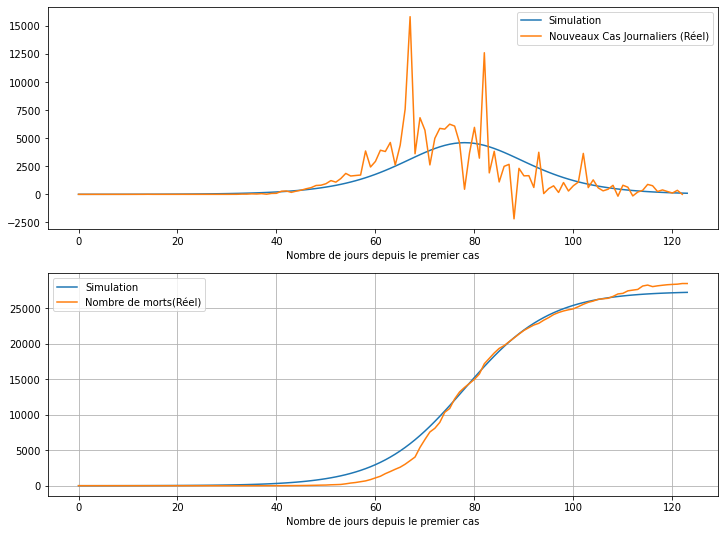

In [13]:

coeffDeces, flagDeces = leastsq(cout, [0.4,0.035,0.005], args=(Table_deces,Table_infection))
print('coeffDeces=',coeffDeces)
#print(coeffDeces)
t=np.arange(len(Table_deces))	
S,I,R,D=SIRD(coeffDeces[0],coeffDeces[1],coeffDeces[2],t)

plt.subplot(211)
plt.plot(t,I,label='Simulation')
plt.plot(t[:-1],derivee(Table_infection,1),label='Nouveaux Cas Journaliers (Réel)')
plt.grid
plt.legend()
plt.xlabel('Nombre de jours depuis le premier cas')

plt.subplot(212)
plt.plot(t,D,label='Simulation')
plt.plot(t,Table_deces,label='Nombre de morts(Réel)')
plt.legend()
plt.grid()
plt.xlabel('Nombre de jours depuis le premier cas')
plt.show()


### VICTOIRE ! ENFIN! Et pour ce qui est du nombre d'infections total? Le modèle va nous fournir le nombre d'infections journalières. Il nous suffit donc d'intégrer (ou de sommer) ça. 

In [14]:
def integrale_degueu(tableau): # mon prof de maths me cracherait dessus s'il voyait ça mais bon , tant que ça marche...
    out=[tableau[0]]
    s=tableau[0]
    for elem in tableau[1:]:
        s+=elem
        out.append(s)
    return out

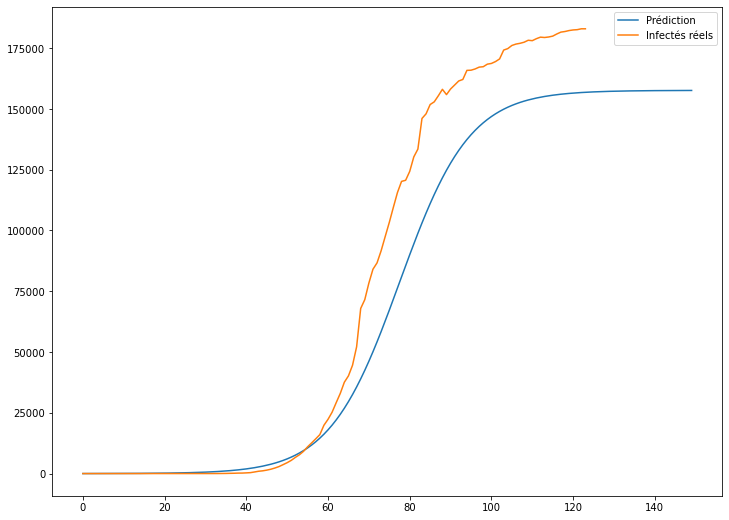

In [15]:
S,I,R,D=SIRD(coeffDeces[0],coeffDeces[1],coeffDeces[2],np.arange(150))
plt.plot(np.arange(150),integrale_degueu(I),label='Prédiction')
plt.plot(t,Table_infection, label='Infectés réels')
plt.legend()
# Effectivement il semblerait que le I attendu par le modèle SIRD soit bel et bien la dérivée du nombre d'infectés totaux

### La prédiction est en dessous des résultats espérés mais le fitting fonctionne désormais ! 